In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import ensemble
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

In [2]:
from F2_train_test_split_functions import func_test_train_split_time
from F1_plot_functions import plot_dated_evdist, plot_single_msoa

## Forecasting EV uptake in MSOAs

In this notebook we run an XGBoost forecasting model for the EV uptake in MSOAs.

In [3]:
df = pd.read_csv('../data/msoa_full_updated_ev_count_onehotencode.csv',index_col=['MSOA11CD','date'])
df.head()

ev_count  index  total_annual_income_2019  \
MSOA11CD  date                                                    
E02000002 2014-01-01         2   3434                   40170.0   
          2014-02-01         2   3434                   40170.0   
          2014-03-01         2   3434                   40170.0   
          2014-04-01         2   3434                   40170.0   
          2014-05-01         2   3434                   40170.0   

                      houseprice_avg_2019  elec_consumption_2019  IMDRank  \
MSOA11CD  date                                                              
E02000002 2014-01-01             357206.0           12874.224118   6621.5   
          2014-02-01             357206.0           12874.224118   6621.5   
          2014-03-01             357206.0           12874.224118   6621.5   
          2014-04-01             357206.0           12874.224118   6621.5   
          2014-05-01             357206.0           12874.224118   6621.5   

                      IMDDecil  pv_count  public_charger_count  \
MSOA11CD  date                                                   
E02000002 2014-01-01       2.0       0.0              2.363636   
          2014-02-01       2.0       1.0              2.363636   
          2014-03-01       2.0       1.0              2.363636   
          2014-04-01       2.0       1.0              2.363636   
          2014-05-01       2.0       1.0              2.363636   

                      private_charger_count  n_months  ev_price  \
MSOA11CD  date                                                    
E02000002 2014-01-01                    0.5         0  25278.29   
          2014-02-01                    0.5         1  25278.29   
          2014-03-01                    0.5         2  25278.29   
          2014-04-01                    0.5         3  25278.29   
          2014-05-01                    0.5         4  25278.29   

                      Rural town and fringe  \
MSOA11CD  date                                
E02000002 2014-01-01                      0   
          2014-02-01                      0   
          2014-03-01                      0   
          2014-04-01                      0   
          2014-05-01                      0   

                      Rural town and fringe in a sparse setting  \
MSOA11CD  date                                                    
E02000002 2014-01-01                                          0   
          2014-02-01                                          0   
          2014-03-01                                          0   
          2014-04-01                                          0   
          2014-05-01                                          0   

                      Rural village and dispersed  \
MSOA11CD  date                                      
E02000002 2014-01-01                            0   
          2014-02-01                            0   
          2014-03-01                            0   
          2014-04-01                            0   
          2014-05-01                            0   

                      Rural village and dispersed in a sparse setting  \
MSOA11CD  date                                                          
E02000002 2014-01-01                                                0   
          2014-02-01                                                0   
          2014-03-01                                                0   
          2014-04-01                                                0   
          2014-05-01                                                0   

                      Urban city and town  \
MSOA11CD  date                              
E02000002 2014-01-01                    0   
          2014-02-01                    0   
          2014-03-01                    0   
          2014-04-01                    0   
          2014-05-01                    0   

                      Urban city and town in a sparse setting  \
MSOA11CD  date

In [4]:
y = df[['ev_count']]
X = df.drop(columns=['ev_count'])

In [5]:
%%time
X_train, y_train, X_test, y_test = func_test_train_split_time(X,y,0.8,1)

CPU times: user 1.46 s, sys: 40 ms, total: 1.5 s
Wall time: 1.5 s


## XGBoost model

Initial attempt, with 100 trees and all the data

In [6]:
# xgb = XGBRegressor(
#     objective="reg:squarederror",
#     max_depth=3,
#     n_estimators=100,
#     learning_rate=0.1,
# )
params = {'n_estimators': 100,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
xgb = ensemble.GradientBoostingRegressor(**params)

In [7]:
%%time
xgb.fit(X_train, y_train.values.ravel())

CPU times: user 1min 36s, sys: 28 ms, total: 1min 36s
Wall time: 1min 36s


GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5)

In [8]:
y_pred_xgb = xgb.predict(X_test)

In [9]:
print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred_xgb), 2))
print('Mean Squared Error:', round(mean_squared_error(y_test, y_pred_xgb), 2))
print("XGB R2 train accuracy: %0.3f" % xgb.score(X_train, y_train))
print("XGB R2 test accuracy: %0.3f" % xgb.score(X_test, y_test))

Mean Absolute Error: 10.73
Mean Squared Error: 510.49
XGB R2 train accuracy: 0.077
XGB R2 test accuracy: -0.509


Visualise a nonzero MSOA performance.

In [10]:
idx = pd.IndexSlice
df_current = df.loc[idx[:,'2021-04-01'],:]
msoa_nonzero_evcount = np.array(df_current[df_current.ev_count > 0].index.droplevel(1))

In [11]:
df_xgb_pred = pd.DataFrame(index=y_test.index)
df_xgb_pred['ev_count'] = y_pred_xgb
df_xgb_pred.head()

ev_count
MSOA11CD  date                
E02000002 2019-11-01  5.841419
          2019-12-01  5.915310
          2020-01-01  7.543666
          2020-02-01  7.568708
          2020-03-01  7.568708

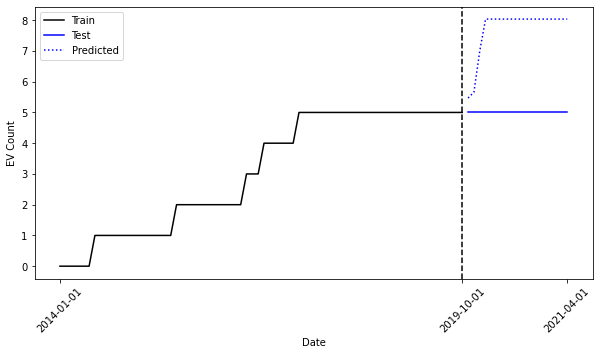

In [12]:
ax = plot_single_msoa(y_train, y_test, y_pred_xgb, np.random.choice(msoa_nonzero_evcount))

Visualise end distribution

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


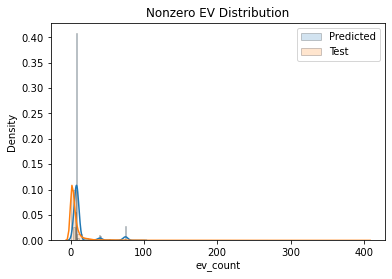

In [13]:
ax = plot_dated_evdist(y_test, y_pred_xgb, msoa_nonzero_evcount, '2021-04-01')
plt.show()

In [14]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(xgb.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test.ev_count.values, y_pred)

# ---  this is annoying : xgb.loss_(y_test, y_pred_xgb.reshape(91840,1))


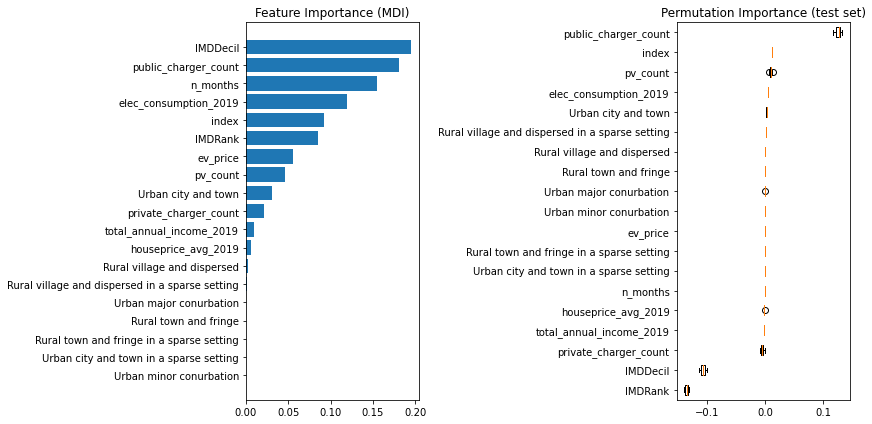

In [15]:
feature_importance = xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(xgb, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_test.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

### Sample zero data

The model is overfitting to the zero data. To check that this is the issue, we sample N=381 zero MSOA regions and retrain.

In [16]:
len(msoa_nonzero_evcount)

4392

In [17]:
msoa_all = np.array(df_current.index.droplevel(1))
msoa_zero_evcount = np.array(list(set(msoa_all)-set(msoa_nonzero_evcount)))
assert len(msoa_all)-len(msoa_nonzero_evcount) == len(msoa_zero_evcount)

In [18]:
len(msoa_zero_evcount)

1348

In [19]:
msoa_zero_sample = msoa_zero_evcount

In [20]:
print(type(msoa_zero_sample))
print(type(msoa_nonzero_evcount))

msoa_sample = np.concatenate([msoa_zero_sample, msoa_nonzero_evcount])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [21]:
df_zero_sample = df.loc[idx[msoa_sample,:],:]
df_zero_sample.shape

(505120, 20)

In [22]:
y_zero_sample = df_zero_sample [['ev_count']]
X_zero_sample = df_zero_sample.drop(columns=['ev_count'])

X_train_zero_sample, y_train_zero_sample , X_test_zero_sample , y_test_zero_sample  = func_test_train_split_time(X_zero_sample,y_zero_sample,0.8,42)

In [23]:
xgb.fit(X_train_zero_sample, y_train_zero_sample.values.ravel())
y_pred_xgb_zero = xgb.predict(X_test_zero_sample)

In [24]:
print('Mean Absolute Error:', round(mean_absolute_error(y_test_zero_sample, y_pred_xgb_zero), 2))
print('Mean Squared Error:', round(mean_squared_error(y_test_zero_sample, y_pred_xgb_zero), 2))
print("XGB R2 train accuracy: %0.3f" % xgb.score(X_train_zero_sample, y_train_zero_sample))
print("XGB R2 test accuracy: %0.3f" % xgb.score(X_test_zero_sample, y_test_zero_sample))

Mean Absolute Error: 10.73
Mean Squared Error: 512.78
XGB R2 train accuracy: 0.077
XGB R2 test accuracy: -0.515


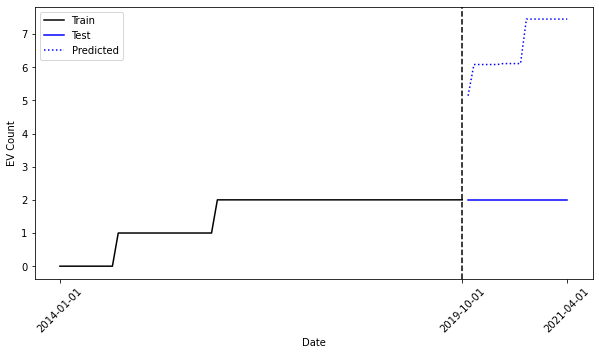

In [25]:
ax = plot_single_msoa(y_train_zero_sample, y_test_zero_sample, y_pred_xgb_zero, np.random.choice(msoa_nonzero_evcount))

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


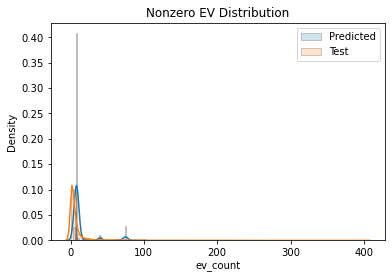

In [26]:
ax = plot_dated_evdist(y_test_zero_sample, y_pred_xgb_zero, msoa_nonzero_evcount, '2021-04-01')

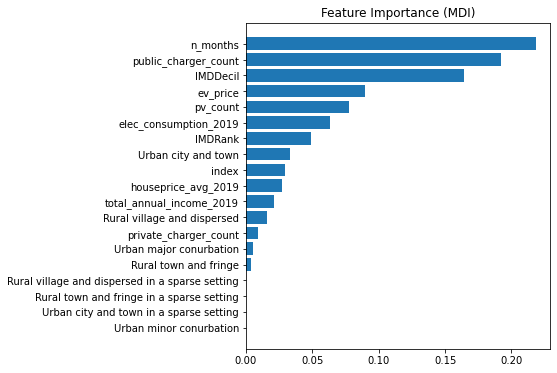

In [53]:
feature_importance = xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

# result = permutation_importance(xgb, X_test, y_test, n_repeats=10,
#                                 random_state=42, n_jobs=2)
# sorted_idx = result.importances_mean.argsort()
# plt.subplot(1, 2, 2)
# plt.boxplot(result.importances[sorted_idx].T,
#             vert=False, labels=np.array(X_test.columns)[sorted_idx])
# plt.title("Permutation Importance (test set)")
# fig.tight_layout()
# plt.show()

plt.savefig('feature_importance_forcast.png', bbox_inches="tight")

## Early stopping


In [28]:
xgb_early_stop = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.1)

In [29]:
xgb_early_stop.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)], 
            early_stopping_rounds=20)

[0]	validation_0-rmse:13.43824	validation_1-rmse:19.37225
[1]	validation_0-rmse:13.22862	validation_1-rmse:20.39255
[2]	validation_0-rmse:13.05520	validation_1-rmse:22.04600
[3]	validation_0-rmse:12.85172	validation_1-rmse:21.91787
[4]	validation_0-rmse:12.70225	validation_1-rmse:21.84164
[5]	validation_0-rmse:12.56001	validation_1-rmse:23.94206
[6]	validation_0-rmse:12.44231	validation_1-rmse:25.79886
[7]	validation_0-rmse:12.30043	validation_1-rmse:25.98376
[8]	validation_0-rmse:12.14048	validation_1-rmse:26.29447
[9]	validation_0-rmse:11.95644	validation_1-rmse:27.28182
[10]	validation_0-rmse:11.85722	validation_1-rmse:27.31176
[11]	validation_0-rmse:11.67463	validation_1-rmse:28.30299
[12]	validation_0-rmse:11.63481	validation_1-rmse:28.34058
[13]	validation_0-rmse:11.53163	validation_1-rmse:28.40599
[14]	validation_0-rmse:11.41966	validation_1-rmse:28.34367
[15]	validation_0-rmse:11.30380	validation_1-rmse:28.47181
[16]	validation_0-rmse:11.24696	validation_1-rmse:29.39597
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

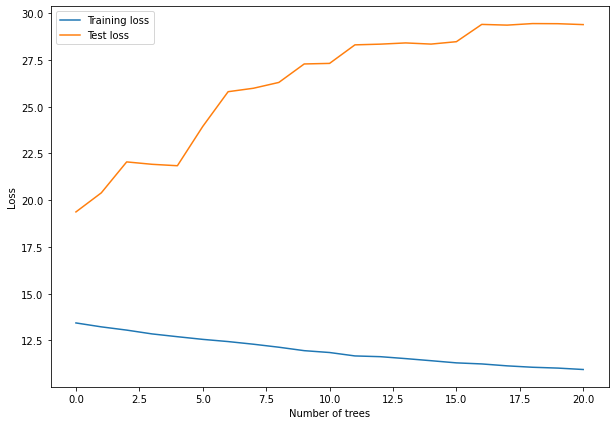

In [30]:
early_stop_results = xgb_early_stop.evals_result()

plt.figure(figsize=(10,7))
plt.plot(early_stop_results["validation_0"]["rmse"], label="Training loss")
plt.plot(early_stop_results["validation_1"]["rmse"], label="Test loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [31]:
y_pred_early_stop = xgb_early_stop.predict(X_test)

In [32]:
print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred_early_stop), 2))
print('Mean Squared Error:', round(mean_squared_error(y_test, y_pred_early_stop), 2))
print("XGB R2 train accuracy: %0.3f" % xgb_early_stop.score(X_train, y_train))
print("XGB R2 test accuracy: %0.3f" % xgb_early_stop.score(X_test, y_test))

Mean Absolute Error: 6.69
Mean Squared Error: 375.29
XGB R2 train accuracy: -0.040
XGB R2 test accuracy: -0.109


## Predict only nonzero MSOAs

In [33]:
df_nonzero = df.loc[idx[msoa_nonzero_evcount,:],:]

y_nonzero = df_nonzero[['ev_count']]
X_nonzero = df_nonzero.drop(columns=['ev_count'])

X_train_nonzero, y_train_nonzero, X_test_nonzero, y_test_nonzero = func_test_train_split_time(X_nonzero,
                                                                                              y_nonzero,0.8,42)

In [34]:
xgb.fit(X_train_nonzero, y_train_nonzero.values.ravel())
y_pred_nonzero = xgb.predict(X_test_nonzero)
print('Mean Absolute Error:', round(mean_absolute_error(y_test_nonzero, y_pred_nonzero), 2))
print('Mean Squared Error:', round(mean_squared_error(y_test_nonzero, y_pred_nonzero), 2))
print("XGB R2 train accuracy: %0.3f" % xgb.score(X_train_nonzero, y_train_nonzero))
print("XGB R2 test accuracy: %0.3f" % xgb.score(X_test_nonzero, y_test_nonzero))

Mean Absolute Error: 10.61
Mean Squared Error: 489.17
XGB R2 train accuracy: 0.077
XGB R2 test accuracy: -0.152


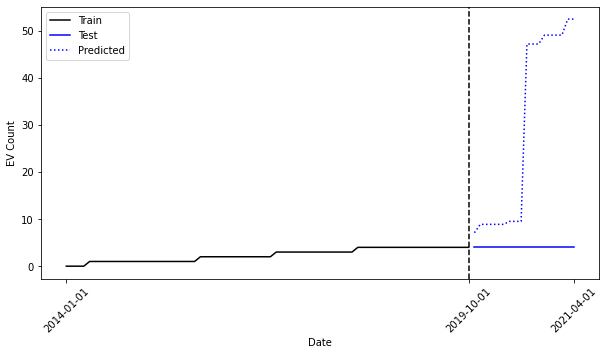

In [42]:
ax = plot_single_msoa(y_train_nonzero, y_test_nonzero,
                      y_pred_nonzero, np.random.choice(msoa_nonzero_evcount))

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


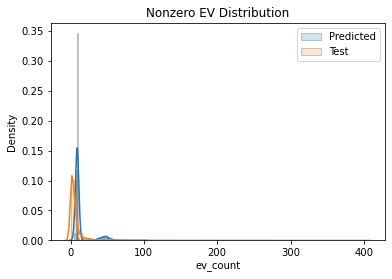

In [36]:
ax = plot_dated_evdist(y_test_nonzero, y_pred_nonzero, msoa_nonzero_evcount, '2021-04-01')

## Add some information about early year EV count

Add a column ev_avg_2015 such that for each MSOA ev_avg_2015 = avg(ev_count in 2015) for that MSOA.

In [37]:
sample_msoa = msoa_nonzero_evcount[0]
print(sample_msoa)

dates = np.sort(np.array(df.index.droplevel(0)[:76]))
dates_14 = dates[:12]
df.loc[idx[sample_msoa, dates_14],:].ev_count.mean()

E02000002


2.0

In [38]:
dates_14

array(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
       '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
       '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01'],
      dtype=object)

In [39]:
df['ev_avg_2014'] = 0

In [40]:
for msoa in msoa_nonzero_evcount:
    df.loc[idx[msoa, :],'ev_avg_2014'] = df.loc[idx[msoa, dates_14],:].ev_count.mean()

In [44]:
df.drop(columns=['elec_consumption_2019'],inplace=True)
df.describe()

,ev_count,index,total_annual_income_2019,houseprice_avg_2019,IMDRank,IMDDecil,pv_count,public_charger_count,private_charger_count,n_months,ev_price,Rural town and fringe,Rural town and fringe in a sparse setting,Rural village and dispersed,Rural village and dispersed in a sparse setting,Urban city and town,Urban city and town in a sparse setting,Urban major conurbation,Urban minor conurbation,ev_avg_2014
count,505120.000000,505120.000000,505120.000000,5.051200e+05,505120.000000,505120.000000,505120.000000,505120.000000,505120.000000,505120.000000,505120.000000,505120.000000,505120.000000,505120.000000,505120.000000,505120.000000,505120.000000,505120.000000,505120.000000,505120.000000
mean,4.758830,2869.500000,44016.229094,2.700825e+05,15417.094434,5.181010,37.093679,2.913150,8.459820,43.500000,29947.946477,0.099129,0.005749,0.107491,0.014983,0.446864,0.002962,0.289547,0.033275,1.379312
std,14.427722,1656.996888,9665.670730,1.527868e+05,8710.966409,2.882877,41.927560,5.120361,7.900627,25.401797,5060.589732,0.298835,0.075605,0.309737,0.121483,0.497169,0.054341,0.453553,0.179355,4.249918
min,0.000000,0.000000,19510.000000,4.862500e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24005.530000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1434.750000,37068.750000,1.619984e+05,8412.416667,3.000000,11.000000,0.755556,2.673077,21.750000,25278.290000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2869.500000,43157.500000,2.360250e+05,15940.700000,5.000000,26.000000,1.472222,6.008772,43.500000,30212.103333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000
75%,4.000000,4304.250000,49961.250000,3.368107e+05,22581.812500,7.500000,49.000000,2.833333,11.922619,65.250000,33085.255000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.333333
max,402.000000,5739.000000,89815.000000,2.789167e+06,32479.800000,10.000000,798.000000,182.500000,49.666667,87.000000,45427.670000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,201.500000


In [45]:
y = df[['ev_count']]
X = df.drop(columns=['ev_count'])

X_ex_train, y_ex_train, X_ex_test, y_ex_test = func_test_train_split_time(X,y,0.7,1)

In [46]:
xgb_early_stop = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1)
xgb_early_stop.fit(X_ex_train, y_ex_train, 
            eval_set=[(X_ex_train, y_ex_train), (X_ex_test, y_ex_test)], 
            early_stopping_rounds=20)

[0]	validation_0-rmse:11.55673	validation_1-rmse:17.62559
[1]	validation_0-rmse:10.49869	validation_1-rmse:16.16046
[2]	validation_0-rmse:9.56112	validation_1-rmse:14.81009
[3]	validation_0-rmse:8.70657	validation_1-rmse:13.60189
[4]	validation_0-rmse:7.94137	validation_1-rmse:12.54664
[5]	validation_0-rmse:7.25593	validation_1-rmse:11.61792
[6]	validation_0-rmse:6.63426	validation_1-rmse:10.80887
[7]	validation_0-rmse:6.08122	validation_1-rmse:10.09264
[8]	validation_0-rmse:5.57402	validation_1-rmse:9.44825
[9]	validation_0-rmse:5.12181	validation_1-rmse:8.87847
[10]	validation_0-rmse:4.71406	validation_1-rmse:8.40193
[11]	validation_0-rmse:4.34908	validation_1-rmse:7.95260
[12]	validation_0-rmse:4.02860	validation_1-rmse:7.61606
[13]	validation_0-rmse:3.73254	validation_1-rmse:7.26658
[14]	validation_0-rmse:3.46532	validation_1-rmse:6.98770
[15]	validation_0-rmse:3.23653	validation_1-rmse:6.75257
[16]	validation_0-rmse:3.02911	validation_1-rmse:6.56945
[17]	validation_0-rmse:2.84295	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
y_ex_pred = xgb_early_stop.predict(X_ex_test)
print('Mean Absolute Error:', round(mean_absolute_error(y_ex_test, y_ex_pred), 2))
print('Mean Squared Error:', round(mean_squared_error(y_ex_test, y_ex_pred), 2))
print("XGB R2 train accuracy: %0.3f" % xgb_early_stop.score(X_ex_train, y_ex_train))
print("XGB R2 test accuracy: %0.3f" % xgb_early_stop.score(X_ex_test, y_ex_test))

Mean Absolute Error: 2.04
Mean Squared Error: 29.23
XGB R2 train accuracy: 0.994
XGB R2 test accuracy: 0.913


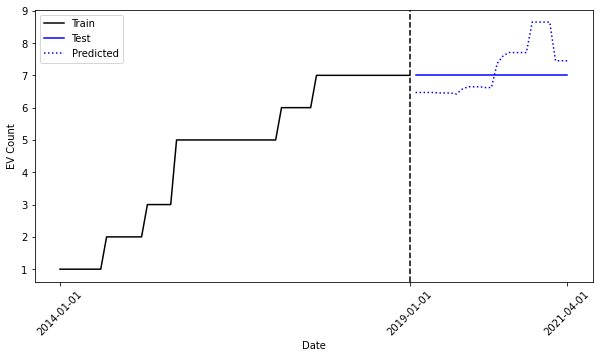

In [52]:
ax = plot_single_msoa(y_ex_train, y_ex_test,
                      y_ex_pred, np.random.choice(msoa_nonzero_evcount))
plt.savefig('forecast1.png', bbox_inches="tight")

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


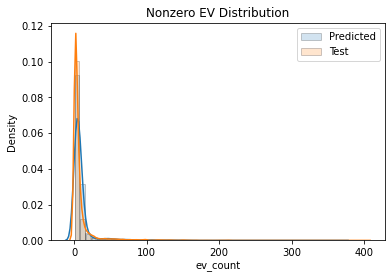

In [49]:
ax = plot_dated_evdist(y_ex_test, y_ex_pred, msoa_nonzero_evcount, '2021-04-01')

In [50]:
# To do: plot feature importances
# also: count number of times the model overpredicts vs underpredicts

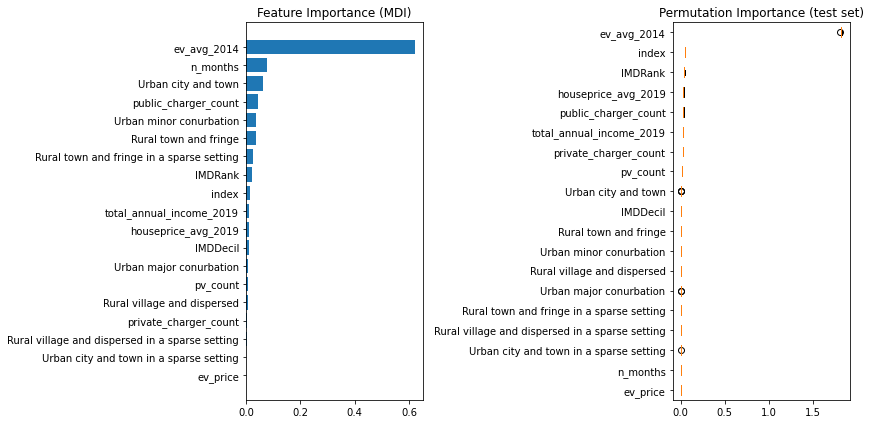

In [51]:
feature_importance = xgb_early_stop.feature_importances_
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_ex_test.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(xgb_early_stop, X_ex_test, y_ex_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_ex_test.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()